# Project Milestone 2

This notebook contians initial data exploration and analysis for the Project Milestone 2
____________________________

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import find_duplicates

### Loading the Data

In [2]:
# main data path and relative paths to the datasets
DATA_PATH = "data/"
DATA_PATH_MOVIESUMMARIES = DATA_PATH + "MovieSummaries/"
DATA_PATH_MOVIELENS = DATA_PATH + "MovieLens/"
DATA_PATH_IMDB = DATA_PATH + "IMDBData/"
DATA_PATH_FINANCIAL = DATA_PATH + "Financial/"

DATASET_PATH = {
    "movie_metadata": DATA_PATH_MOVIESUMMARIES + "movie.metadata.tsv",
    "movie_budget": DATA_PATH_MOVIELENS + "movies_metadata.csv",
    "imdb_ratings": DATA_PATH_IMDB + "title.ratings.tsv",
    "imdb_basics": DATA_PATH_IMDB + "title.basics.tsv",
    "cpi_data": DATA_PATH_FINANCIAL + "CPI.csv",
    "gdp_data": DATA_PATH_FINANCIAL + "GDP.csv",
}
DATASET_COLUMNS = {
    "movie_metadata": [
        "wikipedia_id",
        "freebase_movie_id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
    "movie_budget": [
        "budget",
        "imdb_id",
        "original_title",
        "popularity",
        "release_date",
        "revenue",
        "runtime",
        "title",
        "vote_average",
        "vote_count",
    ],
    "imdb_ratings": ["imdb_id", "imdb_rating", "num_votes"],
    "imdb_basics": [
        "imdb_id",
        "title_type",
        "primary_title",
        "title",
        "is_adult",
        "year",
        "end_year",
        "runtime",
        "genres",
    ],
}

TODO: Add dtypes for all datasets

In [3]:
DATASET_TYPES = {
    "movie_metadata": {
        "wikipedia_id": "string",
        "freebase_movie_id": "string",
        "title": "string",
        "release_date": "string",
        "revenue": "float64",
        "runtime": "string",
        "languages": "object",
        "countries": "object",
        "genres": "object",
    },
    "movie_budget": {
        "budget": "object",
        "imdb_id": "string",
        "original_title": "object",
        "popularity": "object",
        "release_date": "object",
        "revenue": "float64",
        "runtime": "string",
        "title": "object",
        "vote_average": "float64",
        "vote_count": "float64",
    },
    "imdb_ratings": {
        "imdb_id": "string",
        "imdb_rating": "float64",
        "num_votes": "int64",
    },
    "imdb_basics": {
        "imdb_id": "string",
        "title_type": "string",
        "primary_title": "string",
        "title": "string",
        "is_adult": "string",
        "year": "string",
        "end_year": "string",
        "runtime": "string",
        "genres": "string",
    },
}

In [4]:
# load the datasets as pandas dataframes
movie_metadata = pd.read_csv(
    DATASET_PATH["movie_metadata"],
    sep="\t",
    names=DATASET_COLUMNS["movie_metadata"],
    index_col=False,
    header=None,
    dtype=DATASET_TYPES["movie_metadata"],
)
movie_budget = pd.read_csv(
    DATASET_PATH["movie_budget"],
    sep=",",
    usecols=DATASET_COLUMNS["movie_budget"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["movie_budget"],
)
imdb_ratings = pd.read_csv(
    DATASET_PATH["imdb_ratings"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_ratings"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_ratings"],
)
imdb_basics = pd.read_csv(
    DATASET_PATH["imdb_basics"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_basics"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_basics"],
)
cpi_data = pd.read_csv(
    DATASET_PATH["cpi_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)
gdp_data = pd.read_csv(
    DATASET_PATH["gdp_data"],
    sep=",",
    index_col=False,
    skiprows=4,
    header=0,
)

In [5]:
# Print the shapes of the datasets
print("Movie Metadata Shape: ", movie_metadata.shape)
print("MovieLens Budget Shape: ", movie_budget.shape)
print("IMDB Ratings Shape: ", imdb_ratings.shape)
print("IMDB Basics Shape: ", imdb_basics.shape)

Movie Metadata Shape:  (81741, 9)
MovieLens Budget Shape:  (45466, 10)
IMDB Ratings Shape:  (1368131, 3)
IMDB Basics Shape:  (10309011, 9)


#### Data Handling

***`movie_metadata`***

In [6]:
# print percentage of nan values in each column
print(movie_metadata.isna().sum() / len(movie_metadata) * 100)

wikipedia_id          0.000000
freebase_movie_id     0.000000
title                 0.000000
release_date          8.443743
revenue              89.722416
runtime              25.018045
languages             0.000000
countries             0.000000
genres                0.000000
dtype: float64


In [7]:
# since we're mainly interested in the box office revenue, we drop all rows where this value is missing
movie_metadata = movie_metadata.dropna(subset=["revenue"])
# also, we want to merge the cmu movies dataset with the imbds dataset on the moevie name, year and runtime
# that's why we need to drop the rows with missing values in these columns as well
movie_metadata = movie_metadata.dropna(subset=["release_date"])
movie_metadata = movie_metadata.dropna(subset=["runtime"])

# runtime was converted from float to string, so the ".0" needs to be removed
movie_metadata["runtime"] = movie_metadata["runtime"].astype(str).str.replace(".0", "")

# make a column year extracting the year from the release date
movie_metadata["year"] = movie_metadata["release_date"].str[:4]

In [8]:
# see if there are any duplicates in the movie metadata dataset
find_duplicates(movie_metadata, ["title", "release_date", "runtime"])

"No duplicates found in the specified columns: ['title', 'release_date', 'runtime']"

In [9]:
display(movie_metadata.head())

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999


***`movie_budget`***

In [10]:
movie_budget = movie_budget.replace("\\N", np.nan)
print(movie_budget.isna().sum() / len(movie_budget) * 100)

budget            0.000000
imdb_id           0.037391
original_title    0.000000
popularity        0.010997
release_date      0.191352
revenue           0.013197
runtime           0.578454
title             0.013197
vote_average      0.013197
vote_count        0.013197
dtype: float64


In [11]:
movie_budget = movie_budget.dropna(subset=["revenue"])
movie_budget = movie_budget.dropna(subset=["release_date"])
movie_budget = movie_budget.dropna(subset=["runtime"])
movie_budget = movie_budget.dropna(subset=["imdb_id"])

# make a column year extracting the year from the release date
movie_budget["year"] = movie_budget["release_date"].str[:4]

# convert budget to float
movie_budget["budget"] = movie_budget["budget"].astype(float)

In [12]:
find_duplicates(movie_budget, ["imdb_id"]).head(10)

,budget,imdb_id,original_title,popularity,release_date,revenue,runtime,title,vote_average,vote_count,year
38871,0.0,tt0022537,The Viking,0.002362,1931-06-21,0.0,70.0,The Viking,0.0,0.0,1931
16167,0.0,tt0022537,The Viking,0.002362,1931-06-21,0.0,70.0,The Viking,0.0,0.0,1931
949,4.0,tt0022879,A Farewell to Arms,1.914697,1932-12-08,25.0,89.0,A Farewell to Arms,6.2,29.0,1932
15074,4.0,tt0022879,A Farewell to Arms,2.411191,1932-12-08,25.0,89.0,A Farewell to Arms,6.2,29.0,1932
838,0.0,tt0046468,Tsuma,0.096079,1953-04-29,0.0,89.0,Wife,0.0,0.0,1953
30001,0.0,tt0046468,Tsuma,0.619388,1953-04-29,0.0,89.0,Wife,0.0,0.0,1953
7345,0.0,tt0062229,Le Samouraï,9.091288,1967-10-25,39481.0,105.0,Le Samouraï,7.9,187.0,1967
9165,0.0,tt0062229,Le Samouraï,9.091288,1967-10-25,39481.0,105.0,Le Samouraï,7.9,187.0,1967
29374,0.0,tt0067306,King Lear,0.187901,1971-02-04,0.0,137.0,King Lear,8.0,3.0,1971
15702,0.0,tt0067306,King Lear,0.187901,1971-02-04,0.0,137.0,King Lear,8.0,3.0,1971


In [13]:
# drop duplicates since there are some movies with the same imdb id
movie_budget = movie_budget.drop_duplicates(subset=["imdb_id"])

In [14]:
display(movie_budget.head())

,budget,imdb_id,original_title,popularity,release_date,revenue,runtime,title,vote_average,vote_count,year
0,30000000.0,tt0114709,Toy Story,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995
1,65000000.0,tt0113497,Jumanji,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,1995
2,0.0,tt0113228,Grumpier Old Men,11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0,1995
3,16000000.0,tt0114885,Waiting to Exhale,3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0,1995
4,0.0,tt0113041,Father of the Bride Part II,8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0,1995


***`imdb_ratings`***

In [15]:
imdb_ratings = imdb_ratings.replace("\\N", np.nan)
print(imdb_ratings.isna().sum() / len(imdb_ratings) * 100)

imdb_id        0.0
imdb_rating    0.0
num_votes      0.0
dtype: float64


In [16]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

***`imdb_basics`***

In [17]:
imdb_basics = imdb_basics.replace("\\N", np.nan)
print(imdb_basics.isna().sum() / len(imdb_basics) * 100)

imdb_id           0.000000
title_type        0.000000
primary_title     0.000165
title             0.000165
is_adult          0.000010
year             13.401906
end_year         98.888060
runtime          69.875617
genres            4.464415
dtype: float64


In [18]:
find_duplicates(imdb_ratings, ["imdb_id"])

"No duplicates found in the specified columns: ['imdb_id']"

In [19]:
# drop column end_year
imdb_basics = imdb_basics.drop(columns=["end_year"])

# drop rows with missing values, since we are joining the imdb_dataset on this keys later
imdb_basics = imdb_basics.dropna(subset=["year"])
imdb_basics = imdb_basics.dropna(subset=["title"])
imdb_basics = imdb_basics.dropna(subset=["runtime"])

***`us_cpi`***

In [20]:
# since revenue, budget are in USD we only need the inflation data for the US
us_cpi = cpi_data[cpi_data["Country Name"] == "United States"]

# drop last column and other columns that are not needed
us_cpi = us_cpi.drop(
    columns=["Unnamed: 67", "Indicator Name", "Indicator Code", "Country Code"]
)

# drop columns with year > 2012
us_cpi = us_cpi.drop(columns=us_cpi.columns[us_cpi.columns > "2012"])

# transpose the dataframe
us_cpi = us_cpi.transpose().reset_index()

# rename column index to year and column 251 to cpi
us_cpi = us_cpi.rename(columns={"index": "year", 251: "cpi"})

***`us_gdp`***

In [21]:
# since revenue, budget are in USD we only need the data for the US
us_gdp = gdp_data[gdp_data["Country Name"] == "United States"]

# drop last column and other columns that are not needed
us_gdp = us_gdp.drop(
    columns=["Unnamed: 67", "Indicator Name", "Indicator Code", "Country Code"]
)

# drop columns with year > 2012
us_gdp = us_gdp.drop(columns=us_gdp.columns[us_gdp.columns > "2012"])

# transpose the dataframe
us_gdp = us_gdp.transpose().reset_index()

# rename column index to year and column 251 to gdp
us_gdp = us_gdp.rename(columns={"index": "year", 251: "gdp"})

# drop first row since it contains the column names
us_gdp = us_gdp.drop([0])

### Expand and merge the datasets

First we will merge the `imdb_ratings` and `imdb_basics` dataframes, in order to complete the imdb dataset.
After that, we will expand the newly created imdb dataset with `movie_budget` data.

In [22]:
# merge the imdb datasets
imdb_dataset_temp = pd.merge(imdb_basics, imdb_ratings, on="imdb_id", how="left")
# populate imdb dataset with movie budget data
imdb_dataset = pd.merge(
    imdb_dataset_temp,
    movie_budget,
    on="imdb_id",
    how="left",
    suffixes=("", "_movie_budget"),
)
display(imdb_dataset.head())

,imdb_id,title_type,primary_title,title,is_adult,year,runtime,genres,imdb_rating,num_votes,budget,original_title,popularity,release_date,revenue,runtime_movie_budget,title_movie_budget,vote_average,vote_count,year_movie_budget
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short",5.7,2007.0,0.0,Carmencita,1.273072,1894-03-14,0.0,1.0,Carmencita,4.9,18.0,1894
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short",5.8,269.0,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",6.5,1909.0,0.0,Pauvre Pierrot,0.673164,1892-10-28,0.0,4.0,Poor Pierrot,6.1,19.0,1892
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short",5.5,178.0,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short",6.2,2691.0,0.0,Blacksmith Scene,1.061591,1893-05-08,0.0,1.0,Blacksmith Scene,5.8,19.0,1893


In [23]:
imdb_dataset = imdb_dataset.loc[
    :, ~imdb_dataset.columns.str.endswith("_movie_budget")
]  # keep only the columns from the imdb dataset

Next, we will merge the imdb_dataset containing the budget, with the `movie_metadata` dataset. We will mege on the `movie_name`, `year` and `movie_runtime` columns. 

In [24]:
movies_merged = pd.merge(
    movie_metadata,
    imdb_dataset,
    on=["title", "year", "runtime"],
    how="left",
    suffixes=("", "_imdb"),
)
# drop columns with suffix _imdb
movies_merged = movies_merged.loc[:, ~movies_merged.columns.str.endswith("_imdb")]

In [25]:
display(movies_merged.head())

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year,...,title_type,primary_title,is_adult,imdb_rating,num_votes,budget,original_title,popularity,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,0,4.9,56918.0,28000000.0,Ghosts of Mars,7.058599,4.8,299.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,movie,Alexander's Ragtime Band,0,6.8,2268.0,2000000.0,Alexander's Ragtime Band,0.632261,4.8,6.0
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,...,movie,Henry V,0,7.5,31200.0,9000000.0,Henry V,7.307967,7.4,73.0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,...,movie,Mary Poppins,0,7.8,181780.0,6000000.0,Mary Poppins,15.11549,7.4,1217.0
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999,...,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Adjust Revenue and Budget According to CPI

The Consumer Price Index is calculated by measuring the price in one period for a fixed basket of consumer goods and services compared to previous periods.

- **Formula**: 
  $$ \text{Adjusted Value} = \left( \frac{\text{Current Value}}{\text{CPI in Current Year}} \right) \times \text{CPI Base Year} $$

- `Current Value`: The original revenue or budget of the movie.
- `CPI in Current Year`: The Consumer Price Index in the year the movie was released.
- `CPI Base Year`: The Consumer Price Index in the base year (2012).


In [26]:
display(us_cpi.head())

,year,cpi
0,1960,13.563061
1,1961,13.708284
2,1962,13.872615
3,1963,14.044590
4,1964,14.224207


In [27]:
# earliest year for inflation is 1960, so we drop all movies before 1960
movies_merged = movies_merged[movies_merged["year"] >= "1960"]

In [28]:
# calculate revenue_inflation and budget_inflation, different for every year
# find cpi base year
cpi_base_year = us_cpi[us_cpi["year"] == "2012"]["cpi"].values[0]

# merge the movies_merged dataset with the us_inflation dataset on the year column
movies_merged = pd.merge(movies_merged, us_cpi, left_on="year", right_on="year")

# calculate adjusted revenue and budget according to the formula
movies_merged["revenue_adjusted"] = (
    movies_merged["revenue"] / movies_merged["cpi"]
) * cpi_base_year
movies_merged["budget_adjusted"] = (
    movies_merged["budget"] / movies_merged["cpi"]
) * cpi_base_year

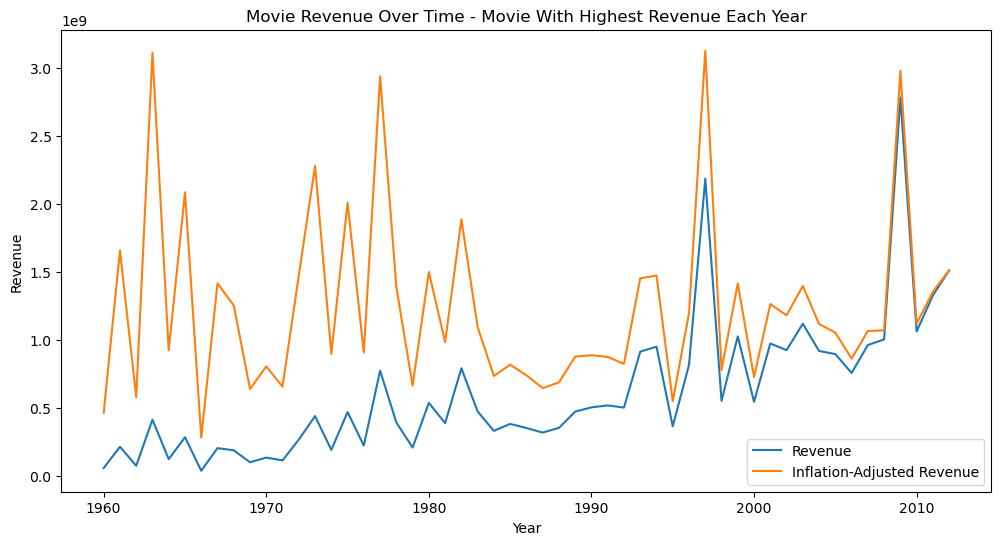

In [29]:
# group by year and get the movie with max revenue and revenue_inflation
annual_revenue = movies_merged.groupby(pd.to_datetime(movies_merged["year"]))[
    ["revenue", "revenue_adjusted"]
].max()

plt.figure(figsize=(12, 6))
plt.plot(annual_revenue.index, annual_revenue["revenue"], label="Revenue")
plt.plot(
    annual_revenue.index,
    annual_revenue["revenue_adjusted"],
    label="Inflation-Adjusted Revenue",
)
plt.title("Movie Revenue Over Time - Movie With Highest Revenue Each Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [30]:
# get top 5 movies with highest revenue inflation
movies_merged.sort_values(by=["revenue_adjusted"], ascending=False).head(5)["title"]

3533                             Titanic
6830       Love with the Proper Stranger
1837                              Avatar
7037    Star Wars Episode IV: A New Hope
7048                        The Exorcist
Name: title, dtype: string

### GDP Data ...

In [31]:
display(us_gdp.head())

,year,gdp
1,1961,5.633000e+11
2,1962,6.051000e+11
3,1963,6.386000e+11
4,1964,6.858000e+11
5,1965,7.437000e+11


TODO: 
***Inflation Adjustment and Comparative Analysis of Movie Revenues:***
- When adjusted for inflation, how does the gross revenue of older movies compare to recent modern movies?
- Is the increase in cinema revenue proportional to the growing budgets for movie production and marketing?



TODO: ***Which factors determine the movie's financial success?***
- Do movies with higher budgets produce higher revenues?
- How do runtime and genre impact a movie's revenue?


TODO: ***Is there a correlation between cinema revenue growth and world economic growth?***
- How does the increase in cinema gross revenue correlate with global economic growth indicators like the world's GDP?
- Are there regional differences in this correlation, and if so, which regions show a stronger relationship?
